# Modeling
"Small" subsets Data from Grocery and Gourmet Food
https://nijianmo.github.io/amazon/index.html (May 1996 - Oct 2018)

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

In [1]:
# Imports
import pandas as pd
import os
import yaml
import pickle
import re

# Data visualisation
import matplotlib.pylab as plt
#import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

config = yaml.safe_load(open('config.yml'))

# Output folder
in_dir = config['in_dir']
out_dir = config['out_dir']


# Create the output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [2]:
# Loading dataset
with open(os.path.join(in_dir, 'product_df.parquet'), 'rb') as handle:
        product_df = pd.read_parquet(handle)

#product_df = product_df.rename(columns={'reviewText':'text'})
product_df.reset_index(inplace=True)
product_df = product_df.rename(columns={'index':'review_id'})
product_df

,review_id,asin,overall,text,summary,date,style,vote
0,0,B00000JCT8,5.0,"Okay, it doesn't use batteries, it doesn't lig...",Little things mean a lot to bicyclists,2000-01-10,None,100
1,1,B00000JCT8,5.0,Great headsets that I use with GMRS Radios for...,Nice headsets,2016-12-21,None,None
2,2,B00000JCT8,2.0,We purchased this head set to communicate via ...,Voice Acitivation Not Working,2016-10-03,None,None
3,3,B00000JCT8,5.0,We use these between me and my wife to help me...,Worked out great,2016-09-06,None,None
4,4,B00000JCT8,4.0,It met expectations.,Four Stars,2016-08-25,None,None
...,...,...,...,...,...,...,...,...
26130,26130,B01H2XF8V8,2.0,USB port started wearing down to the point whe...,"6 months later, hardly functional.",2018-04-08,{'Color:': ' Black'},None
26131,26131,B01H57VY9G,4.0,"liked it , just too big for my surface 3 so ha...","liked it, just too big for my surface 3 ...",2018-04-03,None,None
26132,26132,B01H57VY9G,3.0,Product is kind of heavy. The zippers are awkw...,Heavier than I thought. Does the job okay.,2018-03-15,None,None
26133,26133,B01H57VY9G,4.0,I researched all the available sleeves and sof...,Great all purpose laptop travel case for the m...,2018-03-02,None,None


In [3]:
def break_row(df, col_name='text', max_chars = 255):
    """
    Split any rows in the given column of the given Pandas DataFrame that are
    longer than the specified number of characters at the end of a sentence or
    a space.
    
    Args:
        df (pandas.DataFrame): The DataFrame to modify.
        col_name (str): The name of the column to split.
        max_chars (int): The maximum number of characters allowed in each row.
    
    Returns:
        A new DataFrame with the specified column split into two if necessary.
    """
    new_df = pd.DataFrame(columns=df.columns)
    sentence_end_pattern = r"[.?!]"
    
    for index, row in df.iterrows():
        cell_contents = row[col_name]
        if len(cell_contents) > max_chars:
            # Split the cell contents at the end of a sentence or a space
            split_cells = re.findall(f"(.{{1,{max_chars}}}(?:(?:{sentence_end_pattern})|(?=\s)))\s?", cell_contents)
            new_row = row.copy()
            new_row[col_name] = split_cells[0]
            new_df = new_df.append(new_row)
            for split_cell in split_cells[1:]:
                new_row = row.copy()
                new_row[col_name] = split_cell.strip()
                new_df = new_df.append(new_row)
        else:
            new_df = new_df.append(row)
    
    return new_df

product_df = break_row(product_df)


In [4]:
# Reducing top top 10 products
product_df = product_df[product_df['asin']\
                        .isin(list(product_df.value_counts('asin').head(10).index))]
product_df.reset_index(inplace=True)

## Aspect Extraction

### Rule based

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')


def clean_text(text, stop_words = False, nlp = nlp):
    '''
    Return text with the modifications:
    Normalization (lowercase), Removal of unwanted characters and stopwords and lemmatization
    ''' 
    # Normalization (lowercase)
    text = text.lower()
    # Removal of unwanted characters
    #text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', '', text)
    # too long words: Incomprehensibilities is longest word “in common usage" or single letters
    text = re.sub(r"\b\w{25,90}\b|\b\w{1}\b", "",text)
    
    # Lemmatization
    lemmatized = []
     
    doc = nlp(text)
    for token in doc:
        lemmatized.append(token.lemma_)
    
    # Removing Stopwords
    if stop_words:    
        text = " ".join([word for word in lemmatized if word not in (stop_words)])
    text = re.sub(r'\s+',' ',text)
        
    return text.strip()

In [6]:
def get_absa(text, nlp=nlp):
    '''
    Aspect based Sentiment Analysis
    Input:  text as a string
            Spacy's nlp
    Output: For each noun get the list of Adjectives and their adverbs

    '''

    doc = nlp(text)
    aspects = []
    for sentence in doc.sents:
        description = ''
        aspect = ''
        for token in sentence:
            if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
                aspect = token.text
            if token.pos_ == 'ADJ':
                prepend = ''
                for child in token.children:
                    if child.pos_ != 'ADV':
                        continue
                    prepend += child.text + ' '
                description = prepend + token.text
        if (aspect != '' or description != ''):
            aspects.append({'aspect': aspect,'description': description})
    return aspects

In [7]:
#12min
# Text Cleaning
product_df['text_clean'] = product_df['text'].apply(lambda text: clean_text(text))
# Aspect Based Sentiment Analysis
product_df['absa'] = product_df['text_clean'].apply(lambda text: get_absa(text))

product_df.head()

,index,review_id,asin,overall,text,summary,date,style,vote,text_clean,absa
0,4397,4397,B001Q3M80A,4.0,"<div id=""video-block-R2I6MSXXF5021K"" class=""a-...",Good Camcorder but Produces Shaky Video when Z...,2009-05-27,{'Color:': ' Yellow'},6,"<div id=""video-block-r2i6msxxf5021k"" class=""-s...","[{'aspect': 'type=""hidden', 'description': 'mi..."
1,4397,4397,B001Q3M80A,4.0,"name="""" value=""https://images-na.ssl-images-am...",Good Camcorder but Produces Shaky Video when Z...,2009-05-27,{'Color:': ' Yellow'},6,"name="""" value=""https://images-na.ssl-images-am...","[{'aspect': 'url"">&nbsp', 'description': ''}, ..."
2,4397,4397,B001Q3M80A,4.0,"mentioned, the video codec doesn't work unless...",Good Camcorder but Produces Shaky Video when Z...,2009-05-27,{'Color:': ' Yellow'},6,"mentioned, the video codec doesn' work unless ...","[{'aspect': 'video', 'description': ''}]"
3,4397,4397,B001Q3M80A,4.0,It also means that I can't take the video from...,Good Camcorder but Produces Shaky Video when Z...,2009-05-27,{'Color:': ' Yellow'},6,it also means that can' take the video from th...,[]
4,4397,4397,B001Q3M80A,4.0,I've posted a short video clip taken with the ...,Good Camcorder but Produces Shaky Video when Z...,2009-05-27,{'Color:': ' Yellow'},6,'ve posted short video clip taken with the cam...,"[{'aspect': '', 'description': 'short'}, {'asp..."


In [8]:
# Dataframe for each aspect
absa_df = pd.DataFrame()
for i, row in enumerate(product_df['absa']):
  absa_df_new = pd.DataFrame.from_records(row)
  absa_df_new['index'] = i
  
  absa_df = pd.concat([absa_df, absa_df_new], ignore_index=True)

# Aspects's description per rule based method
aspects_rule_based_df = absa_df.groupby(['aspect'])['description'].apply(lambda x: ', '.join(x))
# Save
aspects_rule_based_df.to_csv(os.path.join(out_dir, 'aspects_rule_based_df.csv'), sep=';', index=False)
aspects_rule_based_df
  

aspect
           own, short, underwater, second, only few, sad,...
#                                 unique, nd unique, compact
%                                               , as perfect
-a1        amazing, electronic, different, fairly unique,...
-a2                                             very similar
                                 ...                        
years                     disassemble, never quite satisfied
yellow                                                      
zone                                                        
zoom       wider, quite smooth, big, amazing, maximum, mu...
zooming                                             very bad
Name: description, Length: 1008, dtype: object

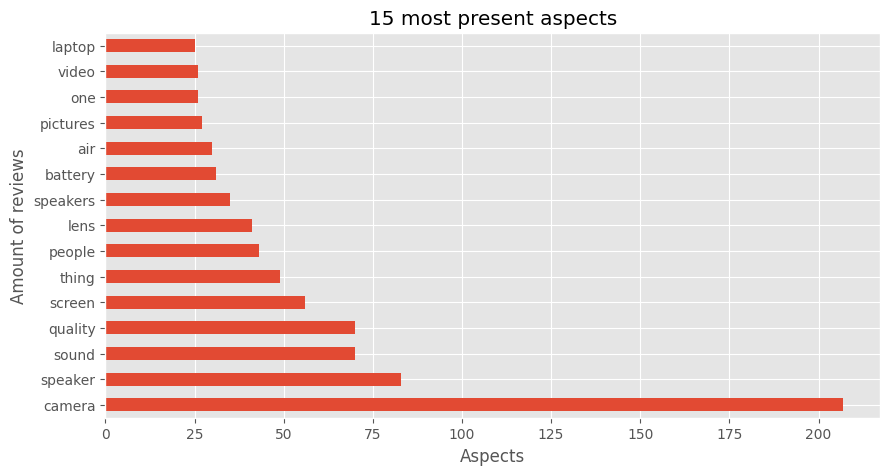

In [9]:
ax = absa_df['aspect'].value_counts().sort_values(ascending=False)[1:16] \
    .plot(kind='barh',
          title='15 most present aspects',
          figsize=(10, 5))
ax.set_xlabel('Aspects')
ax.set_ylabel('Amount of reviews')
plt.show()

In [10]:
# List of aspects: list comprehension is faster than vectorisation 
#https://stackoverflow.com/questions/54028199/are-for-loops-in-pandas-really-bad-when-should-i-care/54028200#54028200
product_df['aspect'] = product_df['absa'].apply(lambda x: [i['aspect'] for i in x if len(i['aspect'])>1 ])
# Remove repeated aspects
product_df['aspect'] = product_df['aspect'].apply(lambda x: list(dict.fromkeys(x)))
# Filling in when aspect is not found
#product_df['aspect'] = product_df['aspect'].apply(lambda x: ['product'] if len(x)==0 else x)
# Removing when aspect is not found
product_df = product_df[product_df['aspect'].map(len) >0]
# Limiting size of text due to memory overload
product_df['text'] = product_df['text'].apply(lambda text: text[:525])

product_df.shape


(2420, 12)

In [11]:
with open(os.path.join(in_dir, 'product_df.parquet'), 'rb') as handle:
        product_df_raw = pd.read_parquet(handle)

In [12]:
# Limiting to top 25 products
top_list = list(product_df['asin'].value_counts().index)[:25]
product_df = product_df[product_df['asin'].isin(top_list)]
product_df.shape

(2420, 12)

In [13]:
import aspect_based_sentiment_analysis as absa
# From https://rafalrolczynski.com/2021/03/07/aspect-based-sentiment-analysis/
nlp_absa = absa.load()

d:\Users\camil\anaconda3\envs\absa\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some layers from the model checkpoint at absa/classifier-rest-0.2 were not used when initializing BertABSClassifier: ['dropout_379']
- This IS expected if you are initializing BertABSClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertABSClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of BertABSClassifier were not initialized from the model checkpoint at absa/classifier-rest-0.2 and are newly initialized: ['dro

In [14]:
# 80min
product_df['absa'] = product_df.apply(lambda x: nlp_absa(text=x['text'], aspects=x['aspect']), axis=1)

# Saving
try:
    product_df.to_parquet(os.path.join(out_dir, 'product_df.parquet'))
except:
    print('Saved as pickle')
    product_df.to_pickle(os.path.join(out_dir, 'product_df.pickle'))

product_df.head()

Saved as pickle


,index,review_id,asin,overall,text,summary,date,style,vote,text_clean,absa,aspect
0,4397,4397,B001Q3M80A,4.0,"<div id=""video-block-R2I6MSXXF5021K"" class=""a-...",Good Camcorder but Produces Shaky Video when Z...,2009-05-27,{'Color:': ' Yellow'},6,"<div id=""video-block-r2i6msxxf5021k"" class=""-s...","CompletedTask(text='<div id=""video-block-R2I6M...","[type=""hidden]"
1,4397,4397,B001Q3M80A,4.0,"name="""" value=""https://images-na.ssl-images-am...",Good Camcorder but Produces Shaky Video when Z...,2009-05-27,{'Color:': ' Yellow'},6,"name="""" value=""https://images-na.ssl-images-am...","CompletedTask(text='name="""" value=""https://ima...","[url"">&nbsp]"
2,4397,4397,B001Q3M80A,4.0,"mentioned, the video codec doesn't work unless...",Good Camcorder but Produces Shaky Video when Z...,2009-05-27,{'Color:': ' Yellow'},6,"mentioned, the video codec doesn' work unless ...","CompletedTask(text=""mentioned, the video codec...",[video]
5,4397,4397,B001Q3M80A,4.0,"I had to copy the video file to my computer, a...",Good Camcorder but Produces Shaky Video when Z...,2009-05-27,{'Color:': ' Yellow'},6,"had to copy the video file to my computer, and...","CompletedTask(text=""I had to copy the video fi...",[video]
6,4397,4397,B001Q3M80A,4.0,upload an HD video for the review. The HD vid...,Good Camcorder but Produces Shaky Video when Z...,2009-05-27,{'Color:': ' Yellow'},6,upload an hd video for the review. the hd vide...,"CompletedTask(text=""upload an HD video for the...",[camera]


In [15]:
# Expanding per aspect
result_df = pd.DataFrame()

for index, row in product_df.iterrows():
  for example in row['absa'].examples:
    new_row = {
    'index': row['index'],
    'text': row['text'],
    'aspect': example.aspect,
    'sentiment':  example.sentiment,
    }
    new_row = pd.DataFrame.from_dict(new_row, orient='index').T
    result_df = pd.concat([result_df, new_row], axis=0, ignore_index=True)

result_df.to_parquet(os.path.join(out_dir, 'result_df.parquet'))

result_df.head()

,index,text,aspect,sentiment
0,4397,"<div id=""video-block-R2I6MSXXF5021K"" class=""a-...","type=""hidden",Sentiment.neutral
1,4397,"name="""" value=""https://images-na.ssl-images-am...","url"">&nbsp",Sentiment.neutral
2,4397,"mentioned, the video codec doesn't work unless...",video,Sentiment.negative
3,4397,"I had to copy the video file to my computer, a...",video,Sentiment.negative
4,4397,upload an HD video for the review. The HD vid...,camera,Sentiment.positive


from transformers import BertTokenizer
#!spacy download en_core_web_sm
import aspect_based_sentiment_analysis as absa
from aspect_based_sentiment_analysis import Professor

recognizer = absa.aux_models.BasicPatternRecognizer()
name = 'absa/classifier-rest-0.2'
model = absa.BertABSClassifier.from_pretrained(name)
tokenizer = BertTokenizer.from_pretrained(name)
professor = absa.Professor() 
text_splitter = absa.sentencizer()  # The English CNN model from SpaCy.
nlp_absa = absa.Pipeline(model, tokenizer, professor, text_splitter)

# Break down the pipeline `call` method.
task = nlp_absa.preprocess(text=text, aspects=aspects)
tokenized_examples = nlp_absa.tokenize(task.examples)
input_batch = nlp_absa.encode(tokenized_examples)
output_batch = nlp_absa.predict(input_batch)
predictions = nlp_absa.review(tokenized_examples, output_batch)
completed_task = nlp_absa.postprocess(task, predictions)
absa.summary(completed_task.examples[0])